In [ ]:
!pip install tensorflow tensorflow_addons tensorflow_datasets tensorflow_hub

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 6.4 MB/s eta 0:00:00


In [ ]:
import os

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_hub as hub
import tensorflow_addons as tfa

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [ ]:
# load the whole dataset, for data info
all_ds   = tfds.load("eurosat", with_info=True)
# load training, testing & validation sets, splitting by 60%, 20% and 20% respectively
train_ds = tfds.load("eurosat", split="train[:60%]")
test_ds  = tfds.load("eurosat", split="train[60%:80%]")
valid_ds = tfds.load("eurosat", split="train[80%:]")

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/27000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/eurosat/rgb/2.0.0.incompleteLN0T29/eurosat-train.tfrecord*...:   0%|      …

Dataset eurosat downloaded and prepared to /root/tensorflow_datasets/eurosat/rgb/2.0.0. Subsequent calls will reuse this data.


In [ ]:
# the class names
class_names = all_ds[1].features["label"].names
# total number of classes (10)
num_classes = len(class_names)
num_examples = all_ds[1].splits["train"].num_examples

Text(0.5, 1.0, 'Bar Plot showing Number of Samples on Each Class')

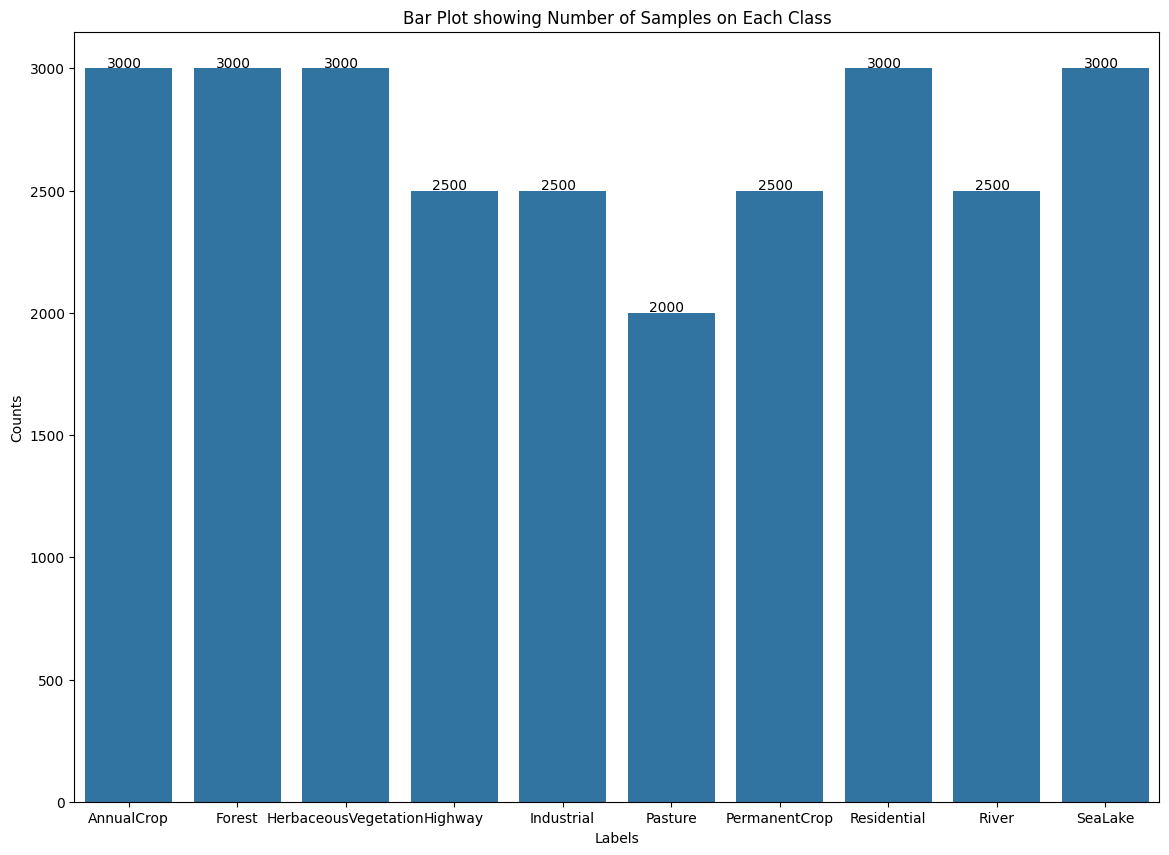

In [ ]:
# make a plot for number of samples on each class
fig, ax = plt.subplots(1, 1, figsize=(14,10))
labels, counts = np.unique(np.fromiter(all_ds[0]["train"].map(lambda x: x["label"]), np.int32),
                       return_counts=True)

plt.ylabel('Counts')
plt.xlabel('Labels')
sns.barplot(x = [class_names[l] for l in labels], y = counts, ax=ax)
for i, x_ in enumerate(labels):
  ax.text(x_-0.2, counts[i]+5, counts[i])
# set the title
ax.set_title("Bar Plot showing Number of Samples on Each Class")
# save the image
# plt.savefig("class_samples.png")

In [ ]:
def prepare_for_training(ds, cache=True, batch_size=64, shuffle_buffer_size=1000):
  if cache:
    if isinstance(cache, str):
      ds = ds.cache(cache)
    else:
      ds = ds.cache()
  ds = ds.map(lambda d: (d["image"], tf.one_hot(d["label"], num_classes)))
  # ds = ds.map(lambda d: (d["sentinel2"], tf.one_hot(d["label"], num_classes)))
  # shuffle the dataset
  ds = ds.shuffle(buffer_size=shuffle_buffer_size)
  # Repeat forever
  ds = ds.repeat()
  # split to batches
  ds = ds.batch(batch_size)
  # `prefetch` lets the dataset fetch batches in the background while the model
  # is training.
  ds = ds.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
  return ds

In [ ]:
batch_size = 64

# preprocess training & validation sets
train_ds = prepare_for_training(train_ds, batch_size=batch_size)
valid_ds = prepare_for_training(valid_ds, batch_size=batch_size)

In [ ]:
# validating shapes
for el in valid_ds.take(1):
  print(el[0].shape, el[1].shape)
for el in train_ds.take(1):
  print(el[0].shape, el[1].shape)

(64, 64, 64, 3) (64, 10)
(64, 64, 64, 3) (64, 10)


In [ ]:
# take the first batch of the training set
batch = next(iter(train_ds))

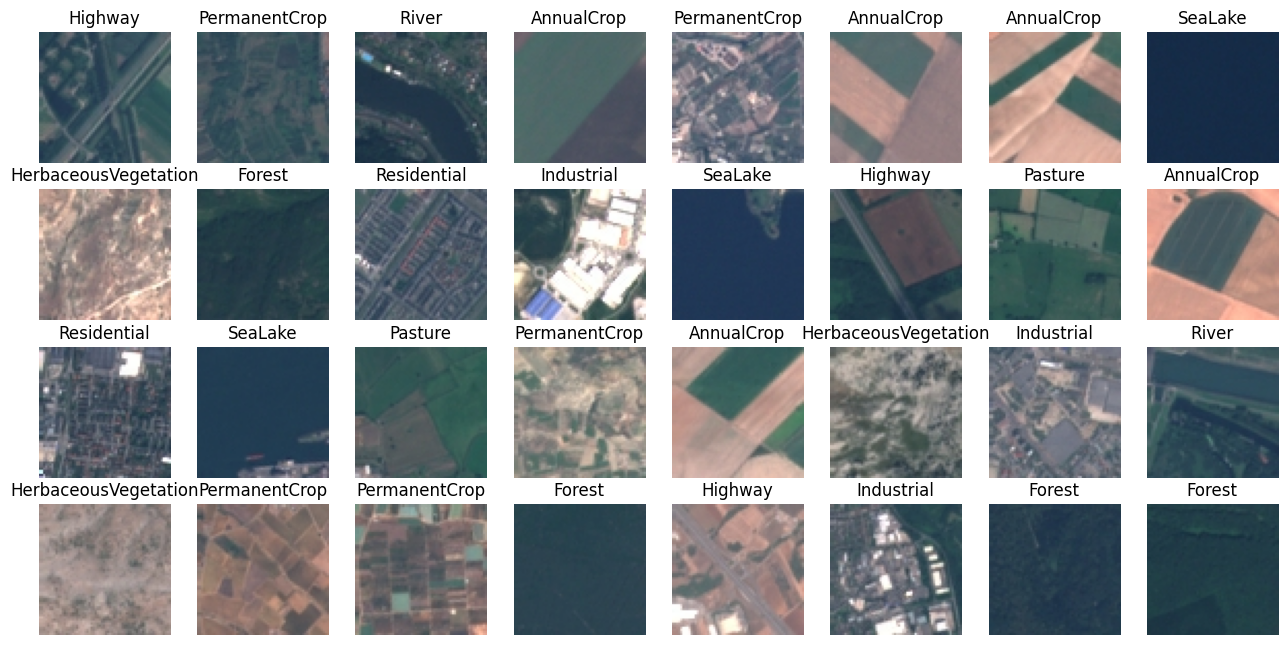

In [ ]:
def show_batch(batch):
  plt.figure(figsize=(16, 16))
  for n in range(min(32, batch_size)):
      ax = plt.subplot(batch_size//8, 8, n + 1)
      # show the image
      plt.imshow(batch[0][n])
      # and put the corresponding label as title upper to the image
      plt.title(class_names[tf.argmax(batch[1][n].numpy())])
      plt.axis('off')
      plt.savefig("sample-images.png")

# showing a batch of images along with labels
show_batch(batch)

In [ ]:
model_url = "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_l/feature_vector/2"

# download & load the layer as a feature vector
keras_layer = hub.KerasLayer(model_url, output_shape=[1280], trainable=True)

In [ ]:
m = tf.keras.Sequential([
  keras_layer,
  tf.keras.layers.Dense(num_classes, activation="softmax")
])
# build the model with input image shape as (64, 64, 3)
m.build([None, 64, 64, 3])
m.compile(
    loss="categorical_crossentropy",
    optimizer="adam",
    metrics=["accuracy", tfa.metrics.F1Score(num_classes)]
)

In [ ]:
m.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1280)              117746848 
                                                                 
 dense (Dense)               (None, 10)                12810     
                                                                 
Total params: 117759658 (449.22 MB)
Trainable params: 117247082 (447.26 MB)
Non-trainable params: 512576 (1.96 MB)
_________________________________________________________________


In [ ]:
model_name = "satellite-classification"
model_path = os.path.join("results", model_name + ".h5")
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(model_path, save_best_only=True, verbose=1)

In [ ]:
# set the training & validation steps since we're using .repeat() on our dataset
# number of training steps
n_training_steps   = int(num_examples * 0.6) // batch_size
# number of validation steps
n_validation_steps = int(num_examples * 0.2) // batch_size

In [ ]:
# train the model
history = m.fit(
    train_ds, validation_data=valid_ds,
    steps_per_epoch=n_training_steps,
    validation_steps=n_validation_steps,
    verbose=1, epochs=20,
    callbacks=[model_checkpoint]
)

Epoch 1/20
253/253 [==============================] - ETA: 0s - loss: 0.3846 - accuracy: 0.8862 - f1_score: 0.8831
Epoch 1: val_loss improved from inf to 0.15783, saving model to results/satellite-classification.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


253/253 [==============================] - 357s 707ms/step - loss: 0.3846 - accuracy: 0.8862 - f1_score: 0.8831 - val_loss: 0.1578 - val_accuracy: 0.9511 - val_f1_score: 0.9491
Epoch 2/20
253/253 [==============================] - ETA: 0s - loss: 0.1637 - accuracy: 0.9498 - f1_score: 0.9481
Epoch 2: val_loss improved from 0.15783 to 0.13906, saving model to results/satellite-classification.h5
253/253 [==============================] - 192s 757ms/step - loss: 0.1637 - accuracy: 0.9498 - f1_score: 0.9481 - val_loss: 0.1391 - val_accuracy: 0.9544 - val_f1_score: 0.9548
Epoch 3/20
253/253 [==============================] - ETA: 0s - loss: 0.1140 - accuracy: 0.9654 - f1_score: 0.9647
Epoch 3: val_loss improved from 0.13906 to 0.12878, saving model to results/satellite-classification.h5
253/253 [==============================] - 178s 705ms/step - loss: 0.1140 - accuracy: 0.9654 - f1_score: 0.9647 - val_loss: 0.1288 - val_accuracy: 0.9598 - val_f1_score: 0.9587
Epoch 4/20
253/253 [===========

In [ ]:
m.save('/content/drive/MyDrive/remote_sensing/efficientnet.h5')

In [ ]:
# load the best weights
m.load_weights(model_path)

In [ ]:
# number of testing steps
n_testing_steps = int(all_ds[1].splits["train"].num_examples * 0.2)
# get all testing images as NumPy array
images = np.array([ d["image"] for d in test_ds.take(n_testing_steps) ])
print("images.shape:", images.shape)
# get all testing labels as NumPy array
labels = np.array([ d["label"] for d in test_ds.take(n_testing_steps) ])
print("labels.shape:", labels.shape)

images.shape: (5400, 64, 64, 3)
labels.shape: (5400,)


In [ ]:
# feed the images to get predictions
predictions = m.predict(images)
# perform argmax to get class index
predictions = np.argmax(predictions, axis=1)
print("predictions.shape:", predictions.shape)

169/169 [==============================] - 16s 71ms/step
predictions.shape: (5400,)


In [ ]:
from sklearn.metrics import f1_score

accuracy = tf.keras.metrics.Accuracy()
accuracy.update_state(labels, predictions)
print("Accuracy:", accuracy.result().numpy())
print("F1 Score:", f1_score(labels, predictions, average="macro"))

Accuracy: 0.9738889
F1 Score: 0.9734742470637325


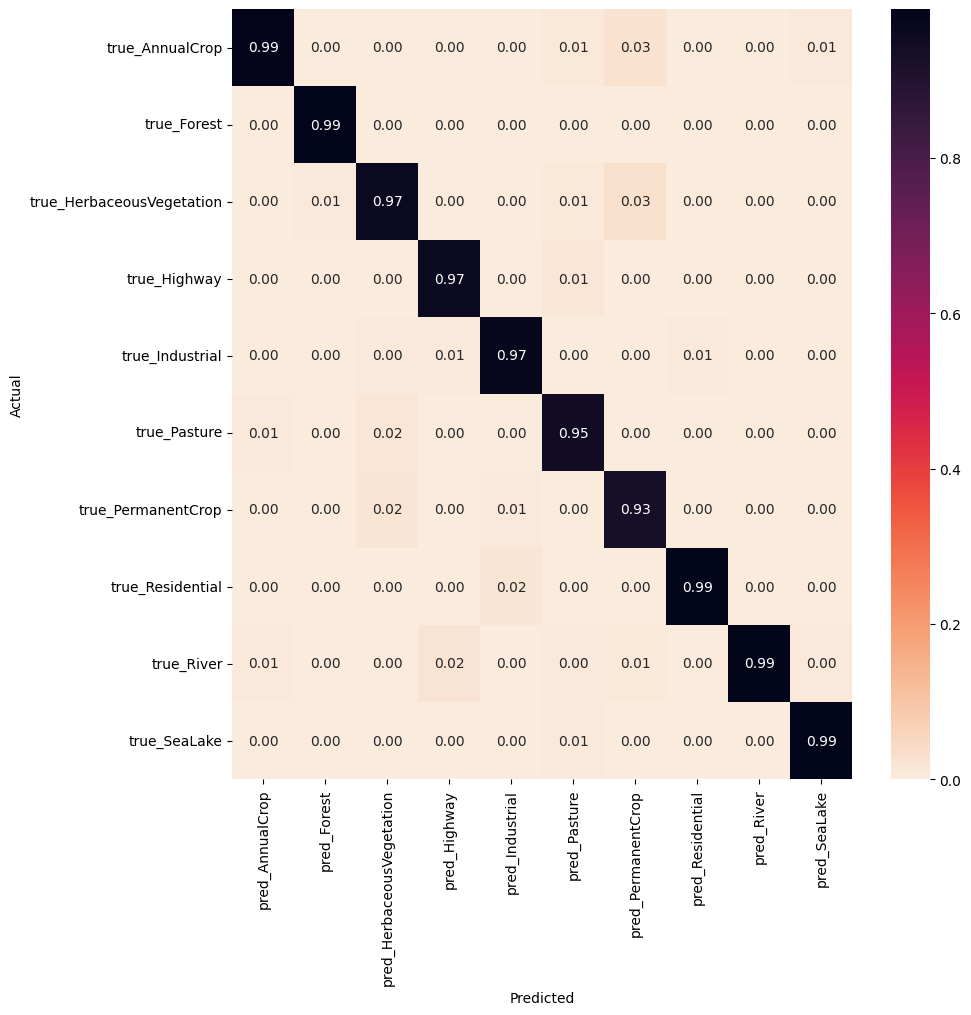

In [ ]:
# compute the confusion matrix
cmn = tf.math.confusion_matrix(labels, predictions).numpy()
# normalize the matrix to be in percentages
cmn = cmn.astype('float') / cmn.sum(axis=0)[:, np.newaxis]
# make a plot for the confusion matrix
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(cmn, annot=True, fmt='.2f',
            xticklabels=[f"pred_{c}" for c in class_names],
            yticklabels=[f"true_{c}" for c in class_names],
            # cmap="Blues"
            cmap="rocket_r"
            )
plt.ylabel('Actual')
plt.xlabel('Predicted')
# plot the resulting confusion matrix
plt.savefig("confusion-matrix.png")
# plt.show()

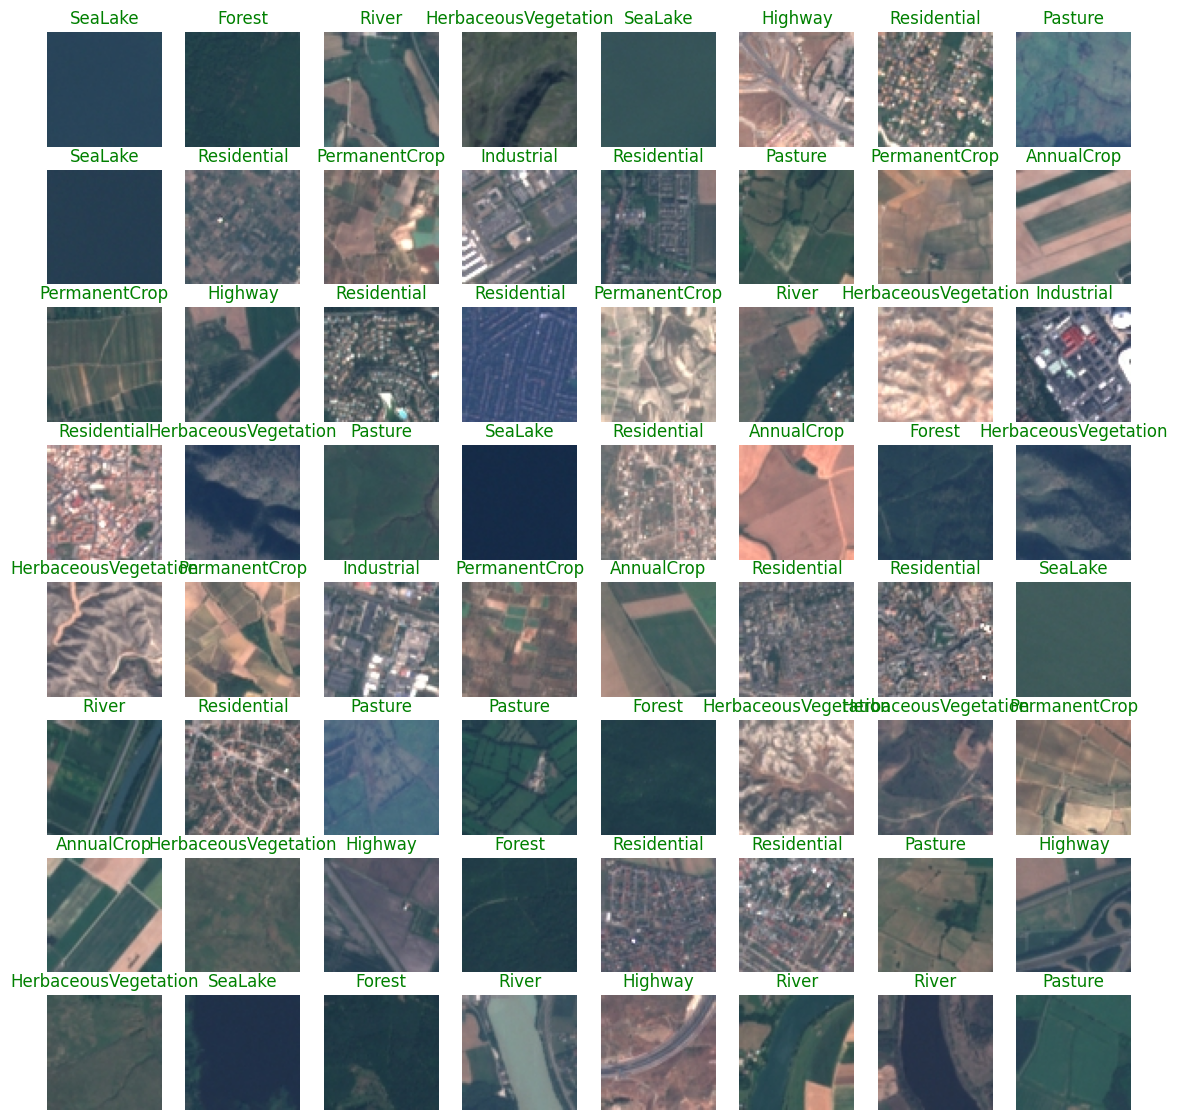

In [ ]:
def show_predicted_samples():
  plt.figure(figsize=(14, 14))
  for n in range(64):
      ax = plt.subplot(8, 8, n + 1)
      # show the image
      plt.imshow(images[n])
      # and put the corresponding label as title upper to the image
      if predictions[n] == labels[n]:
        # correct prediction
        ax.set_title(class_names[predictions[n]], color="green")
      else:
        # wrong prediction
        ax.set_title(f"{class_names[predictions[n]]}/T:{class_names[labels[n]]}", color="red")
      plt.axis('off')
      plt.savefig("predicted-sample-images.png")

# showing a batch of images along with predictions labels
show_predicted_samples()

In [ ]:
from keras.applications.resnet import ResNet50
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
base_model = ResNet50(include_top=False, input_shape=(64, 64, 3))
base_model.summary()


94765736/94765736 [==============================] - 5s 0us/step
Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 64, 64, 3)]          0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 70, 70, 3)            0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 32, 32, 64)           9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 32, 32, 64)           256       ['conv1_conv[0][0]']          
 on)                      

In [ ]:
class_count = len(class_names)
model = Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(units=512, activation="relu"))
model.add(Dense(class_count, activation="softmax"))

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2, 2, 2048)        23587712  
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 dropout (Dropout)           (None, 8192)              0         
                                                                 
 dense_1 (Dense)             (None, 512)               4194816   
                                                                 
 dense_2 (Dense)             (None, 10)                5130      
                                                                 
Total params: 27787658 (106.00 MB)
Trainable params: 27734538 (105.80 MB)
Non-trainable params: 53120 (207.50 KB)
_________________________________________________________________


In [ ]:
model_name = "classification2"
model_path = os.path.join("results", model_name + ".h5")
checkpoint = ModelCheckpoint(filepath=model_path, monitor="val_loss", save_best_only=True)
reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=5)
early_stopping = EarlyStopping(monitor="val_loss", patience=15, restore_best_weights=True, verbose=True)

callback_list = [checkpoint, early_stopping, reduce_lr]

In [ ]:
from tensorflow.keras.optimizers import Adam
model.compile(loss="categorical_crossentropy", optimizer=Adam(learning_rate=1e-4), metrics=["accuracy"])

In [ ]:
res_history = model.fit(
    train_ds,
    steps_per_epoch=n_training_steps,
    validation_steps=n_validation_steps,
    validation_data=valid_ds,
    callbacks=callback_list,
    epochs=20,
    verbose=1,
)

Epoch 1/20
253/253 [==============================] - ETA: 0s - loss: 0.5490 - accuracy: 0.8440

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


253/253 [==============================] - 71s 142ms/step - loss: 0.5490 - accuracy: 0.8440 - val_loss: 0.1972 - val_accuracy: 0.9410 - lr: 1.0000e-04
Epoch 2/20
253/253 [==============================] - 33s 131ms/step - loss: 0.1439 - accuracy: 0.9556 - val_loss: 0.1772 - val_accuracy: 0.9500 - lr: 1.0000e-04
Epoch 3/20
253/253 [==============================] - 23s 92ms/step - loss: 0.0890 - accuracy: 0.9724 - val_loss: 0.2273 - val_accuracy: 0.9381 - lr: 1.0000e-04
Epoch 4/20
253/253 [==============================] - 30s 120ms/step - loss: 0.0507 - accuracy: 0.9827 - val_loss: 0.1344 - val_accuracy: 0.9613 - lr: 1.0000e-04
Epoch 5/20
253/253 [==============================] - 23s 91ms/step - loss: 0.0487 - accuracy: 0.9847 - val_loss: 0.1764 - val_accuracy: 0.9552 - lr: 1.0000e-04
Epoch 6/20
253/253 [==============================] - 24s 95ms/step - loss: 0.0421 - accuracy: 0.9864 - val_loss: 0.2053 - val_accuracy: 0.9515 - lr: 1.0000e-04
Epoch 7/20
253/253 [======================

In [ ]:
model.save('/content/drive/MyDrive/remote_sensing/resnet.h5')

In [ ]:
# load the best weights
model.load_weights(model_path)

In [ ]:

# number of testing steps
n_testing_steps = int(all_ds[1].splits["train"].num_examples * 0.2)
# get all testing images as NumPy array
images = np.array([ d["image"] for d in test_ds.take(n_testing_steps) ])
print("images.shape:", images.shape)
# get all testing labels as NumPy array
labels = np.array([ d["label"] for d in test_ds.take(n_testing_steps) ])
print("labels.shape:", labels.shape)

images.shape: (5400, 64, 64, 3)
labels.shape: (5400,)


In [ ]:
predictions2 = model.predict(images)
# perform argmax to get class index
predictions2 = np.argmax(predictions2, axis=1)
print("predictions.shape:", predictions2.shape)


169/169 [==============================] - 5s 17ms/step
predictions.shape: (5400,)


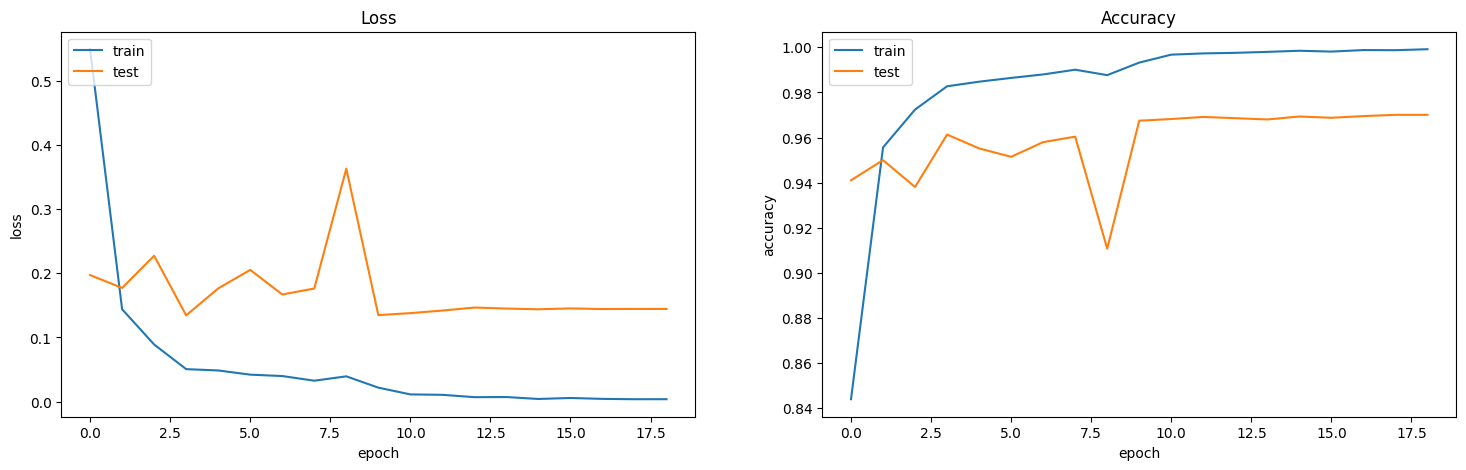

In [ ]:
plt.figure(figsize=(18, 5))

# Loss
plt.subplot(1, 2, 1)
plt.plot(res_history.history["loss"])
plt.plot(res_history.history["val_loss"])
plt.title("Loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "test"], loc="upper left")

# Accuracy
plt.subplot(1, 2, 2)
plt.plot(res_history.history["accuracy"])
plt.plot(res_history.history["val_accuracy"])
plt.title("Accuracy")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.legend(["train", "test"], loc="upper left")

plt.show()


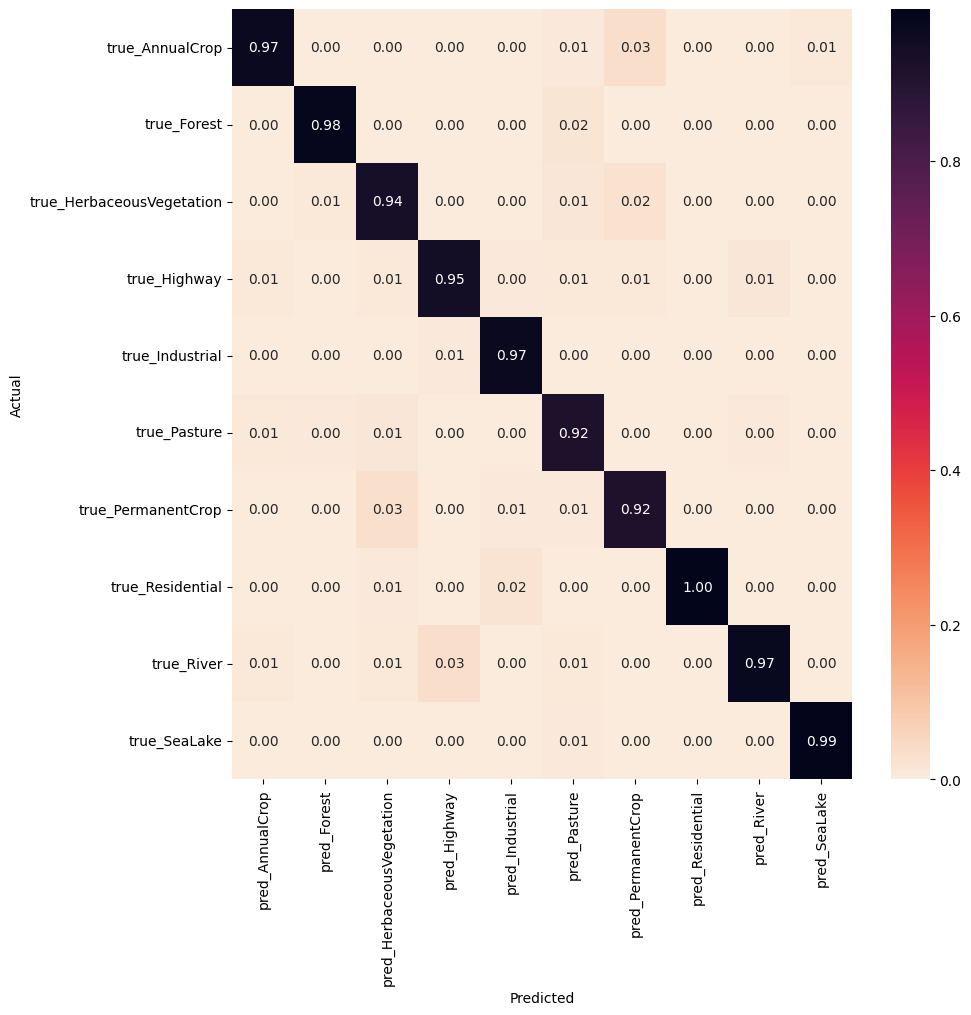

In [ ]:
# compute the confusion matrix
cmn = tf.math.confusion_matrix(labels, predictions2).numpy()
# normalize the matrix to be in percentages
cmn = cmn.astype('float') / cmn.sum(axis=0)[:, np.newaxis]
# make a plot for the confusion matrix
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(cmn, annot=True, fmt='.2f',
            xticklabels=[f"pred_{c}" for c in class_names],
            yticklabels=[f"true_{c}" for c in class_names],
            # cmap="Blues"
            cmap="rocket_r"
            )
plt.ylabel('Actual')
plt.xlabel('Predicted')
# plot the resulting confusion matrix
plt.savefig("confusion-matrix.png")
# plt.show()

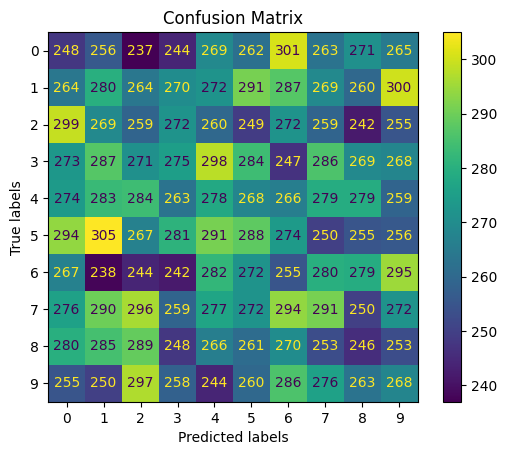

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Generate random data for 10 classes
actual = np.random.randint(0, 10, size=27000)
predicted = np.random.randint(0, 10, size=27000)

cm = confusion_matrix(actual, predicted)
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.arange(10))

cm_display.plot()
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.savefig("confusion-matrix-random-10class.png")  # Save the confusion matrix plot as an image
plt.show()

In [ ]:
#test accuracy
accuracy = tf.keras.metrics.Accuracy()
accuracy.update_state(labels, predictions2)
print("Accuracy:", accuracy.result().numpy())

Accuracy: 0.96166664


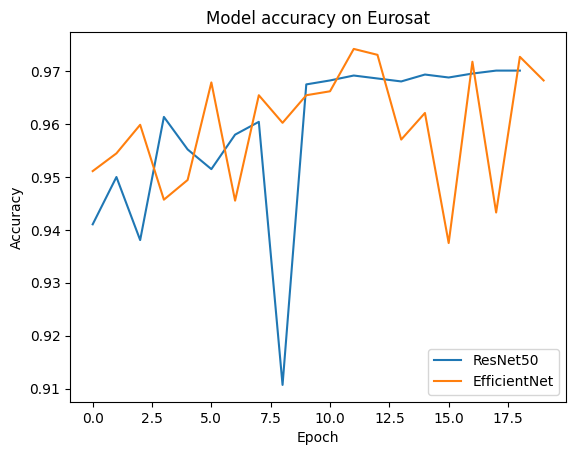

In [ ]:
plt.plot(res_history.history['val_accuracy'], label='ResNet50')
plt.plot(history.history['val_accuracy'], label='EfficientNet')
plt.title('Model accuracy on Eurosat')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.show()